In [ ]:
import os
import numpy as np
import cv2
import kagglehub
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# Download latest version
path = kagglehub.dataset_download("lmslms/ufo-120")

print("Path to dataset files:", path)

100%|██████████| 227M/227M [00:01<00:00, 199MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/lmslms/ufo-120/versions/1


In [ ]:
for root, dirs, files in os.walk(path):
    print(root)

train_val_dir = os.path.join(path, "UFO-120", "train_val")

#all possible directories
possible_hr_dirs = ["hr", "HR"]
possible_lr_dirs = ["lrd", "LR", "lr"]

hr_dir = None
lr_dir = None

for d in possible_hr_dirs:
    candidate = os.path.join(train_val_dir, d)
    if os.path.exists(candidate):
        hr_dir = candidate
        break

for d in possible_lr_dirs:
    candidate = os.path.join(train_val_dir, d)
    if os.path.exists(candidate):
        lr_dir = candidate
        break

if hr_dir and lr_dir:
    print(f"HR directory: {hr_dir}")
    print(f"LR directory: {lr_dir}")
else:
    raise FileNotFoundError("HR or LR folder not found in train_val directory.")

# to ensure that the directories are not empty
if len(os.listdir(hr_dir)) == 0 or len(os.listdir(lr_dir)) == 0:
    raise ValueError("HR or LR folder is empty.")
else:
    print(f"HR images: {len(os.listdir(hr_dir))}, LR images: {len(os.listdir(lr_dir))}")


/root/.cache/kagglehub/datasets/lmslms/ufo-120/versions/1
/root/.cache/kagglehub/datasets/lmslms/ufo-120/versions/1/UFO-120
/root/.cache/kagglehub/datasets/lmslms/ufo-120/versions/1/UFO-120/train_val
/root/.cache/kagglehub/datasets/lmslms/ufo-120/versions/1/UFO-120/train_val/lrd
/root/.cache/kagglehub/datasets/lmslms/ufo-120/versions/1/UFO-120/train_val/mask
/root/.cache/kagglehub/datasets/lmslms/ufo-120/versions/1/UFO-120/train_val/hr
/root/.cache/kagglehub/datasets/lmslms/ufo-120/versions/1/UFO-120/TEST
/root/.cache/kagglehub/datasets/lmslms/ufo-120/versions/1/UFO-120/TEST/lrd
/root/.cache/kagglehub/datasets/lmslms/ufo-120/versions/1/UFO-120/TEST/mask
/root/.cache/kagglehub/datasets/lmslms/ufo-120/versions/1/UFO-120/TEST/hr
HR directory: /root/.cache/kagglehub/datasets/lmslms/ufo-120/versions/1/UFO-120/train_val/hr
LR directory: /root/.cache/kagglehub/datasets/lmslms/ufo-120/versions/1/UFO-120/train_val/lrd
HR images: 1501, LR images: 1500


In [ ]:
img_size = 128
lr_size = 32

def load_images(hr_dir, lr_dir):
    hr_images, lr_images = [], []
    for fname in sorted(os.listdir(hr_dir)):
        hr_path = os.path.join(hr_dir, fname)
        lr_path = os.path.join(lr_dir, fname)
        if os.path.exists(lr_path):
            hr_img = cv2.imread(hr_path)
            hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
            hr_img = cv2.resize(hr_img, (img_size, img_size)) / 255.0

            lr_img = cv2.imread(lr_path)
            lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)
            lr_img = cv2.resize(lr_img, (lr_size, lr_size)) / 255.0

            hr_images.append(hr_img)
            lr_images.append(lr_img)
    return np.array(hr_images, dtype=np.float32), np.array(lr_images, dtype=np.float32)

hr_data, lr_data = load_images(hr_dir, lr_dir)
print(f"HR shape: {hr_data.shape}, LR shape: {lr_data.shape}")

X_train_lr, X_val_lr, X_train_hr, X_val_hr = train_test_split(lr_data, hr_data, test_size=0.1, random_state=42)

HR shape: (1500, 128, 128, 3), LR shape: (1500, 32, 32, 3)


# GENERATOR

In [ ]:
from tensorflow.keras import layers

def residual_block(x):
    res = layers.Conv2D(64, 3, padding='same')(x)
    res = layers.BatchNormalization()(res)
    res = layers.PReLU(shared_axes=[1,2])(res)
    res = layers.Conv2D(64, 3, padding='same')(res)
    res = layers.BatchNormalization()(res)
    return layers.Add()([x, res])

def build_generator():
    inputs = layers.Input(shape=(lr_size, lr_size, 3))
    x = layers.Conv2D(64, 9, padding='same')(inputs)
    x = layers.PReLU(shared_axes=[1,2])(x)
    skip = x

    for _ in range(8):
        x = residual_block(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, skip])

    for _ in range(2):
        x = layers.Conv2D(256, 3, padding='same')(x)
        x = layers.UpSampling2D()(x)
        x = layers.PReLU(shared_axes=[1,2])(x)

    outputs = layers.Conv2D(3, 9, padding='same', activation='tanh')(x)
    return tf.keras.Model(inputs, outputs, name="Generator")

generator = build_generator()
generator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │     15,616 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 32, 32,    │         64 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ p_re_lu[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_1 (PReLU)   │ (None, 32, 32,    │         64 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ p_re_lu_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ p_re_lu[0][0],    │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_2 (PReLU)   │ (None, 32, 32,    │         64 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,928 │ p_re_lu_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ add[0][0],        │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ add_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_5[0][0]  

 Total params: 1,448,835 (5.53 MB)

 Trainable params: 1,446,659 (5.52 MB)

 Non-trainable params: 2,176 (8.50 KB)

# DISCRIMINATOR

In [ ]:
def disc_block(x, filters, stride=1, bn=True):
    x = layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
    if bn: x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    return x

def build_discriminator():
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = disc_block(inputs, 64, bn=False)
    x = disc_block(x, 64, stride=2)
    x = disc_block(x, 128)
    x = disc_block(x, 128, stride=2)
    x = disc_block(x, 256)
    x = disc_block(x, 256, stride=2)
    x = layers.Flatten()(x)
    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs, outputs, name="Discriminator")

discriminator = build_discriminator()
discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    67,109,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 68,259,649 (260.39 MB)

 Trainable params: 68,257,985 (260.38 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [ ]:
discriminator.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                      loss='binary_crossentropy')

discriminator.trainable = False

lr_inp = layers.Input(shape=(lr_size, lr_size, 3))
sr_out = generator(lr_inp)
validity = discriminator(sr_out)

srgan = tf.keras.Model(lr_inp, [sr_out, validity], name="SRGAN")
srgan.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=['mse', 'binary_crossentropy'],
              loss_weights=[1.0, 1e-3])

In [ ]:
EPOCHS = 5
BATCH_SIZE = 8
real_labels = np.ones((BATCH_SIZE, 1))
fake_labels = np.zeros((BATCH_SIZE, 1))

for epoch in range(EPOCHS):
    for i in range(0, len(X_train_lr), BATCH_SIZE):
        lr_batch = X_train_lr[i:i+BATCH_SIZE]
        hr_batch = X_train_hr[i:i+BATCH_SIZE]

        sr_imgs = generator.predict(lr_batch)

        d_loss_real = discriminator.train_on_batch(hr_batch, real_labels[:len(hr_batch)])
        d_loss_fake = discriminator.train_on_batch(sr_imgs, fake_labels[:len(sr_imgs)])
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        g_loss = srgan.train_on_batch(lr_batch, [hr_batch, real_labels[:len(lr_batch)]])

    print(f"Epoch {epoch+1}/{EPOCHS} | D Loss: {d_loss:.4f} | G Loss: {g_loss}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


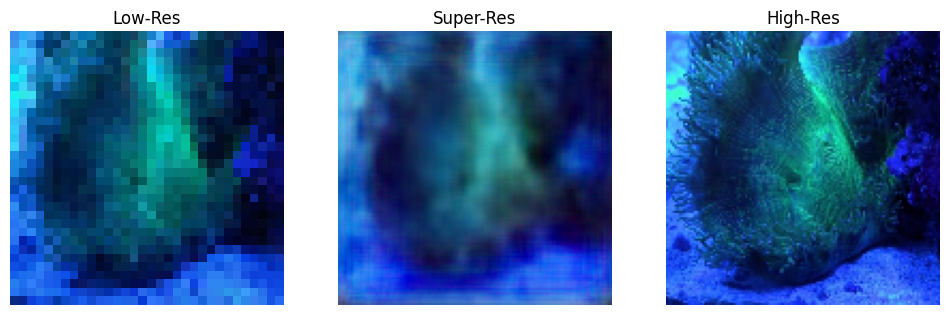

In [ ]:
def visualize_results(idx=0):
    lr_img = X_val_lr[idx:idx+1]
    hr_img = X_val_hr[idx]
    sr_img = generator.predict(lr_img)[0]

    plt.figure(figsize=(12, 4))
    titles = ['Low-Res', 'Super-Res', 'High-Res']
    images = [lr_img[0], sr_img, hr_img]

    for i, img in enumerate(images):
        plt.subplot(1, 3, i+1)
        plt.title(titles[i])
        plt.imshow(np.clip(img, 0, 1))
        plt.axis('off')
    plt.show()

visualize_results()

In [ ]:
# prompt: Code to evalute my SRGAN

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Function to calculate PSNR and SSIM
def evaluate_srgan(generator, lr_images, hr_images):
    sr_images = generator.predict(lr_images)

    total_psnr = 0
    total_ssim = 0

    for i in range(len(sr_images)):
        # Convert images to the correct data type for skimage
        sr_img = (sr_images[i] * 255).astype(np.uint8)
        hr_img = (hr_images[i] * 255).astype(np.uint8)

        total_psnr += psnr(hr_img, sr_img)
        # SSIM requires multichannel=True for color images
        # Adjust win_size and specify channel_axis
        total_ssim += ssim(hr_img, sr_img, win_size=3, channel_axis=2)

    avg_psnr = total_psnr / len(sr_images)
    avg_ssim = total_ssim / len(sr_images)

    return avg_psnr, avg_ssim

# Evaluate the generator on the validation set
avg_psnr, avg_ssim = evaluate_srgan(generator, X_val_lr, X_val_hr)

print(f"Average PSNR on validation set: {avg_psnr:.4f}")
print(f"Average SSIM on validation set: {avg_ssim:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
Average PSNR on validation set: 18.9747
Average SSIM on validation set: 0.3893


In [ ]:
'''bicubic (traditional interpolation technique) baseline prediction (for image upscaling) -
comparing srgan with a baseline method'''

bicubic_up = tf.image.resize(X_val_lr, (X_val_hr.shape[1],X_val_hr.shape[2]), method='bicubic').numpy()

def evaluate_bicubic(bicubic_images, hr_images):
  total_psnr = 0
  total_ssim = 0
  for i in range(len(bicubic_images)):
    bic_img = (bicubic_images[i] * 255).astype(np.uint8)
    hr_img = (hr_images[i] * 255).astype(np.uint8)
    total_psnr += psnr(hr_img, bic_img)
    total_ssim += ssim(hr_img,bic_img, win_size=3, channel_axis=2)
  avg_psnr = total_psnr / len(bicubic_images)
  avg_ssim = total_ssim / len(bicubic_images)
  return avg_psnr, avg_ssim

bic_psnr, bic_ssim = evaluate_bicubic(bicubic_up, X_val_hr)

print(f"Bicubic PSNR on : {bic_psnr:.4f}")
print(f"Bicubic SSIM on : {bic_ssim:.4f}")

Bicubic PSNR on : 17.7556
Bicubic SSIM on : 0.4429


SRGAN achieved a slightly higher PSNR than bicubic, which means that the produced images are closer to the original ones in terms of pixel accuracy, but sacrifices exact structural layout (ssim) of the original image.

SRGAN makes the image look more natural to the human eye, while Bicubic maintains overall structure better.

In [ ]:
#computing pixel level errors

def compute_errors(pred_images,true_images):
  mse = np.mean((pred_images - true_images)**2)
  mae = np.mean(np.abs(pred_images - true_images))
  return mse,mae

#errors for srgan
sr_images = generator.predict(X_val_lr)
sr_mse, sr_mae = compute_errors(sr_images,X_val_hr)

#errors for bicubic
bic_mse, bic_mae = compute_errors(bicubic_up,X_val_hr)

print("Error metrics : ")
print(f"SRGAN MSE: {sr_mse:.6f}, SRGAN MAE: {sr_mae:.6f}")
print(f"Bicubic MSE: {bic_mse:.6f}, Bicubic MAE: {bic_mae:.6f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Error metrics : 
SRGAN MSE: 0.012933, SRGAN MAE: 0.081882
Bicubic MSE: 0.016598, Bicubic MAE: 0.094360


SRGAN outperforms Bicubic in terms of both MSE and MAE, which means:

SRGAN’s predictions are numerically more accurate and closer to the ground truth HR images compared to Bicubic.

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def compute_errors(pred_images, true_images):
    mse = np.mean((pred_images - true_images) ** 2)
    mae = np.mean(np.abs(pred_images - true_images))
    return mse, mae

def evaluate_model(model, lr_images, hr_images, name="MODEL", batch_size=8):
    pred_images = model.predict(lr_images, batch_size=batch_size, verbose=0)
    pred_images = np.clip(pred_images, 0, 1)

    total_psnr = total_ssim = 0
    for i in range(len(pred_images)):
        sr_img = (pred_images[i] * 255).astype(np.uint8)
        hr_img = (hr_images[i] * 255).astype(np.uint8)
        total_psnr += psnr(hr_img, sr_img)
        total_ssim += ssim(hr_img, sr_img, win_size=3, channel_axis=2)

    avg_psnr = total_psnr / len(pred_images)
    avg_ssim = total_ssim / len(pred_images)
    mse, mae = compute_errors(pred_images, hr_images)

    print(f"[{name}] PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}, MSE: {mse:.6f}, MAE: {mae:.6f}")
    return avg_psnr, avg_ssim, mse, mae

# EDSR

In [ ]:
from tensorflow.keras import Model

def build_edsr(scale=4, num_res_blocks=4):
    def res_block(x_in):
        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x_in)
        x = layers.Conv2D(64, 3, padding='same')(x)
        return layers.Add()([x_in, x])

    inputs = layers.Input(shape=(X_train_lr.shape[1], X_train_lr.shape[2], 3))
    x = layers.Conv2D(64, 3, padding='same')(inputs)
    for _ in range(num_res_blocks):
        x = res_block(x)
    x = layers.Conv2D(3 * (scale**2), 3, padding='same')(x)
    outputs = layers.Lambda(lambda z: tf.nn.depth_to_space(z, scale))(x)
    return Model(inputs, outputs, name="EDSR")

edsr_model = build_edsr()
edsr_model.compile(optimizer='adam', loss='mae')
edsr_model.summary()

edsr_model.fit(X_train_lr, X_train_hr, epochs=10, batch_size=8, validation_data=(X_val_lr, X_val_hr))
edsr_psnr, edsr_ssim, edsr_mse, edsr_mae = evaluate_model(edsr_model, X_val_lr, X_val_hr, name="EDSR")

Model: "EDSR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 32, 32,    │      1,792 │ input_layer_7[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_67[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_68[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 32, 32,    │          0 │ conv2d_67[0][0],  │
│                     │ 64)               │            │ conv2d_69[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 32, 32,    │     36,928 │ add_25[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_70[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 32, 32,    │          0 │ add_25[0][0],     │
│                     │ 64)               │            │ conv2d_71[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 32, 32,    │     36,928 │ add_26[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_72[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_27 (Add)        │ (None, 32, 32,    │          0 │ add_26[0][0],     │
│                     │ 64)               │            │ conv2d_73[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 32, 32,    │     36,928 │ add_27[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_74[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_28 (Add)        │ (None, 32, 32,    │          0 │ add_27[0][0],     │
│                     │ 64)               │            │ conv2d_75[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 32, 32,    │     27,696 │ add_28[0][0]      │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 128, 128,  │          0 │ conv2d_76[0][0]   │
│                     │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 324,912 (1.24 MB)

 Trainable params: 324,912 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.1320 - val_loss: 0.0771
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0799 - val_loss: 0.0736
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0775 - val_loss: 0.0732
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0762 - val_loss: 0.0728
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0742 - val_loss: 0.0712
Epoch 6/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0756 - val_loss: 0.0763
Epoch 7/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0732 - val_loss: 0.0734
Epoch 8/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0736 - val_loss: 0.0705
Epoch 9/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0721 - val_loss: 0.0707
Epoch 10/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0724 - val_loss: 0.0692
[EDSR] PSNR: 20.4579, SSIM: 0.4604, MSE: 0.010326, MAE: 0.069167


# RDN

In [ ]:
def build_rdn(scale=4, num_res_blocks=3):
    def dense_block(x_in):
        concat_feat = [x_in]
        x = x_in
        for _ in range(3):
            x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
            concat_feat.append(x)
            x = layers.Concatenate()(concat_feat)
        return x

    inputs = layers.Input(shape=(X_train_lr.shape[1], X_train_lr.shape[2], 3))
    x = layers.Conv2D(64, 3, padding='same')(inputs)
    for _ in range(num_res_blocks):
        x = dense_block(x)
    x = layers.Conv2D(3 * (scale**2), 3, padding='same')(x)
    outputs = layers.Lambda(lambda z: tf.nn.depth_to_space(z, scale))(x)
    return Model(inputs, outputs, name="RDN")

rdn_model = build_rdn()
rdn_model.compile(optimizer='adam', loss='mae')
rdn_model.summary()

rdn_model.fit(X_train_lr, X_train_hr, epochs=10, batch_size=8, validation_data=(X_val_lr, X_val_hr))
rdn_psnr, rdn_ssim, rdn_mse, rdn_mae = evaluate_model(rdn_model, X_val_lr, X_val_hr, name="RDN")

Model: "RDN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 32, 32,    │      1,792 │ input_layer_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_77[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_77[0][0],  │
│ (Concatenate)       │ 128)              │            │ conv2d_78[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 32, 32,    │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ conv2d_77[0][0],  │
│ (Concatenate)       │ 192)              │            │ conv2d_78[0][0],  │
│                     │                   │            │ conv2d_79[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 32, 32,    │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ conv2d_77[0][0],  │
│ (Concatenate)       │ 256)              │            │ conv2d_78[0][0],  │
│                     │                   │            │ conv2d_79[0][0],  │
│                     │                   │            │ conv2d_80[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 32, 32,    │    147,520 │ concatenate_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 32,    │          0 │ concatenate_2[0]… │
│ (Concatenate)       │ 320)              │            │ conv2d_81[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 32, 32,    │    184,384 │ concatenate_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ concatenate_2[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_81[0][0],  │
│                     │                   │            │ conv2d_82[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 32, 32,    │    221,248 │ concatenate_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 32, 32,    │          0 │ concatenate_2[0]… │
│ (Concatenate)       │ 448)              │            │ conv2d_81[0][0],  │
│                     │                   │            │ conv2d_82[0][0],  │
│                     │                   │            │ conv2d_83[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_84 (Conv2D)  │ (None, 32, 32,    │    258,112 │ concatenate_5[0]

 Total params: 1,937,776 (7.39 MB)

 Trainable params: 1,937,776 (7.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 104ms/step - loss: 0.1374 - val_loss: 0.0742
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0757 - val_loss: 0.0719
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0736 - val_loss: 0.0772
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0738 - val_loss: 0.0748
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0747 - val_loss: 0.0706
Epoch 6/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0721 - val_loss: 0.0702
Epoch 7/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0721 - val_loss: 0.0694
Epoch 8/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0718 - val_loss: 0.0718
Epoch 9/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0713 - val_loss: 0.0690
Epoch 10/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0697 - val_loss: 0.0688
[RDN] PSNR: 20.5750, SSIM: 0.4716, MSE: 0.010158, MAE: 0.068719


# ESRGAN

In [ ]:
#training only the ESRGAN generator (like SRResNet), since GAN training is heavy.
def build_esrgan(scale=4, num_res_blocks=5):
    def res_block(x_in):
        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x_in)
        x = layers.Conv2D(64, 3, padding='same')(x)
        return layers.Add()([x_in, x])

    inputs = layers.Input(shape=(X_train_lr.shape[1], X_train_lr.shape[2], 3))
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    for _ in range(num_res_blocks):
        x = res_block(x)
    x = layers.Conv2D(3 * (scale**2), 3, padding='same')(x)
    outputs = layers.Lambda(lambda z: tf.nn.depth_to_space(z, scale))(x)
    return Model(inputs, outputs, name="ESRGAN")

esrgan_model = build_esrgan()
esrgan_model.compile(optimizer='adam', loss='mae')
esrgan_model.summary()

esrgan_model.fit(X_train_lr, X_train_hr, epochs=10, batch_size=8, validation_data=(X_val_lr, X_val_hr))
esrgan_psnr, esrgan_ssim, esrgan_mse, esrgan_mae = evaluate_model(esrgan_model, X_val_lr, X_val_hr, name="ESRGAN")

Model: "ESRGAN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_88 (Conv2D)  │ (None, 32, 32,    │      1,792 │ input_layer_9[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_89 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_88[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_90 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_89[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_29 (Add)        │ (None, 32, 32,    │          0 │ conv2d_88[0][0],  │
│                     │ 64)               │            │ conv2d_90[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_91 (Conv2D)  │ (None, 32, 32,    │     36,928 │ add_29[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_92 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_91[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_30 (Add)        │ (None, 32, 32,    │          0 │ add_29[0][0],     │
│                     │ 64)               │            │ conv2d_92[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_93 (Conv2D)  │ (None, 32, 32,    │     36,928 │ add_30[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_93[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_31 (Add)        │ (None, 32, 32,    │          0 │ add_30[0][0],     │
│                     │ 64)               │            │ conv2d_94[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 32, 32,    │     36,928 │ add_31[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_95[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 32, 32,    │          0 │ add_31[0][0],     │
│                     │ 64)               │            │ conv2d_96[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 32, 32,    │     36,928 │ add_32[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_97[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_33 (Add)        │ (None, 32, 32,    │          0 │ add_32[0][0],   

 Total params: 398,768 (1.52 MB)

 Trainable params: 398,768 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.1343 - val_loss: 0.0830
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0816 - val_loss: 0.0742
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0761 - val_loss: 0.0766
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0762 - val_loss: 0.0764
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0759 - val_loss: 0.0707
Epoch 6/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0738 - val_loss: 0.0722
Epoch 7/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0747 - val_loss: 0.0704
Epoch 8/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0732 - val_loss: 0.0714
Epoch 9/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0741 - val_loss: 0.0710
Epoch 10/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0725 - val_loss: 0.0700
[ESRGAN] PSNR: 20.4788, SSIM: 0.4506, MSE: 0.010259, MAE: 0.069937


In [ ]:
results = {
    "Bicubic": [bic_psnr, bic_ssim, bic_mse, bic_mae],
    "SRGAN": [avg_psnr, avg_ssim, sr_mse, sr_mae],
    "EDSR": [edsr_psnr, edsr_ssim, edsr_mse, edsr_mae],
    "RDN": [rdn_psnr, rdn_ssim, rdn_mse, rdn_mae],
    "ESRGAN": [esrgan_psnr, esrgan_ssim, esrgan_mse, esrgan_mae]
}

import pandas as pd
df = pd.DataFrame(results, index=["PSNR", "SSIM", "MSE", "MAE"]).T
print(df)

              PSNR      SSIM       MSE       MAE
Bicubic  17.755633  0.442901  0.016598  0.094360
SRGAN    18.974711  0.389310  0.012933  0.081882
EDSR     20.457925  0.460399  0.010326  0.069167
RDN      20.574974  0.471615  0.010158  0.068719
ESRGAN   20.478849  0.450594  0.010259  0.069937


SRGAN, EDSR, RDN, ESRGAN perform better than Bicubic, producing sharper and more accurate images. **RDN is the best**, with the highest PSNR/SSIM and lowest errors, followed by EDSR and ESRGAN. **SRGAN is better than Bicubic** but has lower SSIM because it focuses on realistic textures rather than exact pixel match. Overall, **RDN and EDSR give the best quality**.
